In [1]:
# setup
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import sys
from ppi_py import ppi_ols_ci, classical_ols_ci, ppi_ols_pointestimate

df = pd.read_csv("../Data/5_SurveySampleLLM.csv.gz")

Covs = ['PedPed', 'Barrier', 'CrossingSignal', 'NumberOfCharacters',
        'DiffNumberOFCharacters', 'LeftHand', 'Man', 'Woman', 'Pregnant',
        'Stroller', 'OldMan', 'OldWoman', 'Boy', 'Girl', 'Homeless',
        'LargeWoman', 'LargeMan', 'Criminal', 'MaleExecutive',
        'FemaleExecutive', 'FemaleAthlete', 'MaleAthlete', 'FemaleDoctor',
        'MaleDoctor', 'Dog', 'Cat', 
        'Intervention'
        ]

sys.version

'3.11.2 (tags/v3.11.2:878ead1, Feb  7 2023, 16:38:35) [MSC v.1934 64 bit (AMD64)]'

In [2]:
# very few missing predicted values for the dependent variable
print("Number of NAs Saved: ",df["Saved"].isna().sum())
print("Number of NAs gpt4turbo_wp_Saved: ",df["gpt4turbo_wp_Saved"].isna().sum())
print("Number of NAs gpt4o_wp_Saved: ",df["gpt4o_wp_Saved"].isna().sum())
print("Number of NAs gpt35turbo0125_wp_Saved: ",df["gpt35turbo0125_wp_Saved"].isna().sum())

Number of NAs Saved:  0
Number of NAs gpt4turbo_wp_Saved:  0
Number of NAs gpt4o_wp_Saved:  6
Number of NAs gpt35turbo0125_wp_Saved:  2


In [3]:
# functions to calculate weights for conjoint experiment
def CalcTheoreticalInt(r):
    # this function is applied to each row (r)
    if r["Intervention"]==0:
        if r["Barrier"]==0:
            if r["PedPed"]==1: p = 0.48
            else: p = 0.32
            
            if r["CrossingSignal"]==0:   p = p * 0.48
            elif r["CrossingSignal"]==1: p = p * 0.2
            else: p = p * 0.32
        else: p = 0.2

    else: 
        if r["Barrier"]==0:
            if r["PedPed"]==1: 
                p = 0.48
                if r["CrossingSignal"]==0: p = p * 0.48
                elif r["CrossingSignal"]==1: p = p * 0.32
                else: p = p * 0.2
            else: 
                p = 0.2
                if r["CrossingSignal"]==0: p = p * 0.48
                elif r["CrossingSignal"]==1: p = p * 0.2
                else: p = p * 0.32
        else: p = 0.32  
    
    return(p)  
        
def calcWeightsTheoretical(profiles):
    
    p = profiles.apply(CalcTheoreticalInt, axis=1)

    weight = 1/p 

    return(weight) 

            

In [4]:
# function from PPI to calculate stats
def _ols_get_stats(
    pointest,
    X,
    Y,
    Yhat,
    X_unlabeled,
    Yhat_unlabeled,
    w=None,
    w_unlabeled=None,
    use_unlabeled=True,
):
    """Computes the statistics needed for the OLS-based prediction-powered inference.

    Args:
        pointest (ndarray): A point estimate of the coefficients.
        X (ndarray): Covariates for the labeled data set.
        Y (ndarray): Labels for the labeled data set.
        Yhat (ndarray): Predictions for the labeled data set.
        X_unlabeled (ndarray): Covariates for the unlabeled data set.
        Yhat_unlabeled (ndarray): Predictions for the unlabeled data set.
        w (ndarray, optional): Sample weights for the labeled data set.
        w_unlabeled (ndarray, optional): Sample weights for the unlabeled data set.
        use_unlabeled (bool, optional): Whether to use the unlabeled data set.

    Returns:
        grads (ndarray): Gradient of the loss function with respect to the coefficients.
        grads_hat (ndarray): Gradient of the loss function with respect to the coefficients, evaluated using the labeled predictions.
        grads_hat_unlabeled (ndarray): Gradient of the loss function with respect to the coefficients, evaluated using the unlabeled predictions.
        inv_hessian (ndarray): Inverse Hessian of the loss function with respect to the coefficients.
    """
    n = Y.shape[0]
    N = Yhat_unlabeled.shape[0]
    d = X.shape[1]
    w = np.ones(n) if w is None else w / np.sum(w) * n
    w_unlabeled = (
        np.ones(N)
        if w_unlabeled is None
        else w_unlabeled / np.sum(w_unlabeled) * N
    )

    hessian = np.zeros((d, d))
    grads_hat_unlabeled = np.zeros(X_unlabeled.shape)
    if use_unlabeled:
        for i in range(N):
            hessian += (
                w_unlabeled[i]
                / (N + n)
                * np.outer(X_unlabeled[i], X_unlabeled[i])
            )
            grads_hat_unlabeled[i, :] = (
                w_unlabeled[i]
                * X_unlabeled[i, :]
                * (np.dot(X_unlabeled[i, :], pointest) - Yhat_unlabeled[i])
            )

    grads = np.zeros(X.shape)
    grads_hat = np.zeros(X.shape)
    for i in range(n):
        hessian += (
            w[i] / (N + n) * np.outer(X[i], X[i])
            if use_unlabeled
            else w[i] / n * np.outer(X[i], X[i])
        )
        grads[i, :] = w[i] * X[i, :] * (np.dot(X[i, :], pointest) - Y[i])
        grads_hat[i, :] = (
            w[i] * X[i, :] * (np.dot(X[i, :], pointest) - Yhat[i])
        )

    inv_hessian = np.linalg.inv(hessian).reshape(d, d)
    return grads, grads_hat, grads_hat_unlabeled, inv_hessian

def _power_analysis_stats(grads, grads_hat, inv_hessian):
    grads_ = grads - grads.mean(axis=0)
    grads_hat_ = grads_hat - grads_hat.mean(axis=0)
    cov = inv_hessian @ (grads_[:,None,:] * grads_hat_[:,:,None]).mean(axis=0) @ inv_hessian
    var = inv_hessian @ (grads_[:,None,:]*grads_[:,:,None]).mean(axis=0) @ inv_hessian
    var_hat = inv_hessian @ (grads_hat_[:,None,:]*grads_hat_[:,:,None]).mean(axis=0) @ inv_hessian
    rhos_sq = np.diag(cov)**2/(np.diag(var)*np.diag(var_hat))
    sigmas_sq = np.diag(var)
    return rhos_sq, sigmas_sq

def _estimate_ppi_SE(n, N, rho_sq, var_Y):
    if N == np.inf:
        return np.sqrt(var_Y*(1-rho_sq)/n)
    if N == 0:
        return np.sqrt(var_Y/n)
    var_ppi = var_Y*(1-rho_sq*N/(n+N))/n
    return np.sqrt(var_ppi)

def _estimate_classical_SE(n, var_Y):
    return np.sqrt(var_Y/n)

In [5]:
# calculate amce for intervention
def compute_amce(data, x, y, alpha=0.05):

    # specify regression for swerve or stay in lane
    if x=="Intervention":
        
        # calculate weights
        data.loc[:,"weights"] = calcWeightsTheoretical(data)
    
        # drop rows with missing values on dependent variable
        dd = data.dropna(subset=y)

        # if X=1 characters die if AV serves, if X=0 characters if AV stays
        X = dd["Intervention"]
        X = sm.add_constant(X)

        # define model with standard errors clustered on UserID
        model = sm.WLS(dd[y], X, weights=dd["weights"])
    

    # specify regression for relationship to vehicle
    if x=="Barrier":

        # consider only dilemmas without legality and only pedestrians vs passengers
        data_sub = data.loc[(data["CrossingSignal"]==0) & (data["PedPed"]==0), :].copy()

        # calculate weights
        data_sub.loc[:,"weights"] = calcWeightsTheoretical(data_sub)

        # drop rows with missing values on dependent variable
        dd = data_sub.dropna(subset=y)
        
        # if X=1 passengers die and if X=0 pedestrians die
        X = dd["Barrier"]

        # recode to estimate the preference for pedestrians over passengers 
        X = 1 - X
        X = sm.add_constant(X)

        # define model with standard errors clustered on UserID
        model = sm.WLS(dd[y], X, weights=dd["weights"])

    
    # specify regression for legality
    if x=="CrossingSignal": 
        
        # consider dilemmas with legality and only pedestrians vs pedestrians
        data_sub = data.loc[(data["CrossingSignal"]!=0) & (data["PedPed"]==1), :].copy()

        # calculate weights
        data_sub.loc[:,"weights"] = calcWeightsTheoretical(data_sub)

        # drop rows with missing values on dependent variable
        dd = data_sub.dropna(subset=y)

        # if X=1 pedestrians cross on a green light, if X=2 pedestrians cross on a red light 
        X = dd["CrossingSignal"]

        # create dummy variable to estimate preference for pedestrians that cross legally (1) vs legally (0)
        X = 2 - X 
        X = sm.add_constant(X)

        # define model with standard errors clustered on UserID
        model = sm.WLS(dd[y], X, weights=dd["weights"])

    

    # Specify regressions for the remaining six attributes
    if x=="Utilitarian":
        
        # consider dilemmas that compare 'More' versus 'Less' characters
        data_sub = data.loc[(data["ScenarioType"]=="Utilitarian") & (data["ScenarioTypeStrict"]=="Utilitarian"), :].copy()

        # calculate weights
        data_sub.loc[:,"weights"] = calcWeightsTheoretical(data_sub)

        # drop rows with missing values on dependent variable
        dd = data_sub.dropna(subset=y)
        dd = dd.rename(columns = {'AttributeLevel': 'Utilitarian'})

        # create dummy variable to estimate the preference for sparing more characters
        X = (dd.loc[:,"Utilitarian"]=="More").astype(int)
        X = sm.add_constant(X)

        # define model with standard errors clustered on UserID
        model = sm.WLS(dd[y], X, weights=dd["weights"])


    if x=="Species":
        
        # consider dilemmas that compare humans versus animals 
        data_sub = data.loc[(data["ScenarioType"]=="Species") & (data["ScenarioTypeStrict"]=="Species"), :].copy()

        # calculate weights
        data_sub.loc[:,"weights"] = calcWeightsTheoretical(data_sub)

        # drop rows with missing values on dependent variable
        dd = data_sub.dropna(subset=y)
        dd = dd.rename(columns = {'AttributeLevel': 'Species'})

        # create dummy variable to estimate the preference for sparing humans
        X = (dd.loc[:,"Species"]=="Hoomans").astype(int)
        X = sm.add_constant(X)

        # define model with standard errors clustered on UserID
        model = sm.WLS(dd[y], X, weights=dd["weights"])
    

    if x=="Gender":
        
        # consider dilemmas that compare women versus men
        data_sub = data.loc[(data["ScenarioType"]=="Gender") & (data["ScenarioTypeStrict"]=="Gender"), :].copy()

        # calculate weights
        data_sub.loc[:,"weights"] = calcWeightsTheoretical(data_sub)

        # drop rows with missing values on dependent variable
        dd = data_sub.dropna(subset=y)
        dd = dd.rename(columns = {'AttributeLevel': 'Gender'})

        # create dummy variable to estimate the preference for sparing women
        X = (dd.loc[:,"Gender"]=="Female").astype(int)
        X = sm.add_constant(X)

        # define model with standard errors clustered on UserID
        model = sm.WLS(dd[y], X, weights=dd["weights"])


    if x=="Fitness":
        
        # consider dilemmas that compare fit characters versus those that are not
        data_sub = data.loc[(data["ScenarioType"]=="Fitness") & (data["ScenarioTypeStrict"]=="Fitness"), :].copy()

        # calculate weights
        data_sub.loc[:,"weights"] = calcWeightsTheoretical(data_sub)

        # drop rows with missing values on dependent variable
        dd = data_sub.dropna(subset=y)
        dd = dd.rename(columns = {'AttributeLevel': 'Fitness'})

        # create dummy variable to estimate the preference for sparing fit characters
        X = (dd.loc[:,"Fitness"]=="Fit").astype(int)
        X = sm.add_constant(X)

        # define model with standard errors clustered on UserID
        model = sm.WLS(dd[y], X, weights=dd["weights"])


    if x=="Age":
        
        # consider dilemmas that compare younger versus older characters
        data_sub = data.loc[(data["ScenarioType"]=="Age") & (data["ScenarioTypeStrict"]=="Age"), :].copy()

        # calculate weights
        data_sub.loc[:,"weights"] = calcWeightsTheoretical(data_sub)

        # drop rows with missing values on dependent variable
        dd = data_sub.dropna(subset=y)
        dd = dd.rename(columns = {'AttributeLevel': 'Age'})

        # create dummy variable to estimate the preference for sparing younger characters
        X = (dd.loc[:,"Age"]=="Young").astype(int)
        X = sm.add_constant(X)

        # define model with standard errors clustered on UserID
        model = sm.WLS(dd[y], X, weights=dd["weights"])

    
    if x=="Social Status":
        
        # consider dilemmas that compare high status versus low status characters
        data_sub = data.loc[(data["ScenarioType"]=="Social Status") & (data["ScenarioTypeStrict"]=="Social Status"), :].copy()

        # calculate weights
        data_sub.loc[:,"weights"] = calcWeightsTheoretical(data_sub)

        # drop rows with missing values on dependent variable
        dd = data_sub.dropna(subset=y)
        dd = dd.rename(columns = {'AttributeLevel': 'Social Status'})

        # create dummy variable to estimate the preference for sparing high status characters
        X = (dd.loc[:,"Social Status"]=="High").astype(int)
        X = sm.add_constant(X)

        # define model with standard errors clustered on UserID
        model = sm.WLS(dd[y], X, weights=dd["weights"])



    # fit model and extract estimates
    fit = model.fit(cov_type = 'cluster', cov_kwds = {'groups': dd["UserID"]})
    coef = fit.params[x]
    ci = fit.conf_int(alpha=alpha).loc[x]

    # store results
    res = pd.DataFrame({
        'x': [x],
        'y': [y],
        'pointest_pooled': [coef],
        'conf_low_pooled': [ci[0]],
        'conf_high_pooled': [ci[1]]
    })

    return(res)

    


In [6]:
# function to calculate amce with ppi 
def compute_amce_ppi(n_data, N_data, x, y, alpha=0.05):

    # specify regression for swerve or stay in lane
    if x=="Intervention":
        
        # calculate weights
        n_data.loc[:,"weights"] = calcWeightsTheoretical(n_data)
        N_data.loc[:,"weights"] = calcWeightsTheoretical(N_data)
    
        # drop rows with missing values on dependent variable
        n_dd = n_data.dropna(subset=y)
        N_dd = N_data.dropna(subset=y)

        # if X=1 characters die if AV serves, if X=0 characters if AV stays
        n_X = n_dd["Intervention"]               
        N_X = N_dd["Intervention"]

        # add intercept
        n_X = np.column_stack((np.ones(n_X.shape[0]), n_X))
        N_X = np.column_stack((np.ones(N_X.shape[0]), N_X))

        # gold standard data
        n_Y_human   = n_dd["Saved"].to_numpy()    # observed outcomes
        n_Y_silicon = n_dd[y].to_numpy()          # predicted outcomes
        n_weights = n_dd["weights"].to_numpy()    # define weights

        # unlabeled data
        N_Y_silicon = N_dd[y].to_numpy()          # predicted outcomes
        N_weights = N_dd["weights"].to_numpy()    # define weights



    # specify regression for relationship to vehicle
    if x=="Barrier":

        # consider only dilemmas without legality and only pedestrians vs passengers
        n_data_sub = n_data.loc[(n_data["CrossingSignal"]==0) & (n_data["PedPed"]==0), :].copy()
        N_data_sub = N_data.loc[(N_data["CrossingSignal"]==0) & (N_data["PedPed"]==0), :].copy()

        # calculate weights
        n_data_sub.loc[:,"weights"] = calcWeightsTheoretical(n_data_sub)
        N_data_sub.loc[:,"weights"] = calcWeightsTheoretical(N_data_sub)

        # drop rows with missing values on dependent variable
        n_dd = n_data_sub.dropna(subset=y)
        N_dd = N_data_sub.dropna(subset=y)
        
        # if X=1 passengers die and if X=0 pedestrians die
        n_X = n_dd["Barrier"]
        N_X = N_dd["Barrier"]

        # recode to estimate the preference for pedestrians over passengers 
        n_X = 1 - n_X
        N_X = 1 - N_X

        # add intercept
        n_X = np.column_stack((np.ones(n_X.shape[0]), n_X))
        N_X = np.column_stack((np.ones(N_X.shape[0]), N_X))

        # gold standard data
        n_Y_human   = n_dd["Saved"].to_numpy()    # observed outcomes
        n_Y_silicon = n_dd[y].to_numpy()          # predicted outcomes
        n_weights = n_dd["weights"].to_numpy()    # define weights

        # unlabeled data
        N_Y_silicon = N_dd[y].to_numpy()          # predicted outcomes
        N_weights = N_dd["weights"].to_numpy()    # define weights

    

    # specify regression for legality
    if x=="CrossingSignal": 
        
        # consider dilemmas with legality and only pedestrians vs pedestrians
        n_data_sub = n_data.loc[(n_data["CrossingSignal"]!=0) & (n_data["PedPed"]==1), :].copy()
        N_data_sub = N_data.loc[(N_data["CrossingSignal"]!=0) & (N_data["PedPed"]==1), :].copy()

        # calculate weights
        n_data_sub.loc[:,"weights"] = calcWeightsTheoretical(n_data_sub)
        N_data_sub.loc[:,"weights"] = calcWeightsTheoretical(N_data_sub)

        # drop rows with missing values on dependent variable
        n_dd = n_data_sub.dropna(subset=y)
        N_dd = N_data_sub.dropna(subset=y)

        # if X=1 pedestrians cross on a green light, if X=2 pedestrians cross on a red light 
        n_X = n_dd["CrossingSignal"]
        N_X = N_dd["CrossingSignal"]

        # create dummy variable to estimate preference for pedestrians that cross legally (1) vs legally (0)
        n_X = 2 - n_X 
        N_X = 2 - N_X 

        # add intercept
        n_X = np.column_stack((np.ones(n_X.shape[0]), n_X))
        N_X = np.column_stack((np.ones(N_X.shape[0]), N_X))

        # gold standard data
        n_Y_human   = n_dd["Saved"].to_numpy()    # observed outcomes
        n_Y_silicon = n_dd[y].to_numpy()          # predicted outcomes
        n_weights = n_dd["weights"].to_numpy()    # define weights

        # unlabeled data
        N_Y_silicon = N_dd[y].to_numpy()          # predicted outcomes
        N_weights = N_dd["weights"].to_numpy()    # define weights
    


    # Specify regressions for the remaining six attributes
    if x=="Utilitarian":
        
        # consider dilemmas that compare 'More' versus 'Less' characters
        n_data_sub = n_data.loc[(n_data["ScenarioType"]=="Utilitarian") & (n_data["ScenarioTypeStrict"]=="Utilitarian"), :].copy()
        N_data_sub = N_data.loc[(N_data["ScenarioType"]=="Utilitarian") & (N_data["ScenarioTypeStrict"]=="Utilitarian"), :].copy()

        # calculate weights
        n_data_sub.loc[:,"weights"] = calcWeightsTheoretical(n_data_sub)
        N_data_sub.loc[:,"weights"] = calcWeightsTheoretical(N_data_sub)

        # drop rows with missing values on dependent variable
        n_dd = n_data_sub.dropna(subset=y)
        N_dd = N_data_sub.dropna(subset=y)
        
        # rename column to extract coefficient from result
        n_dd = n_dd.rename(columns = {'AttributeLevel': 'Utilitarian'})
        N_dd = N_dd.rename(columns = {'AttributeLevel': 'Utilitarian'})

        # create dummy variable to estimate the preference for sparing more characters
        n_X = (n_dd.loc[:,"Utilitarian"]=="More").astype(int)
        N_X = (N_dd.loc[:,"Utilitarian"]=="More").astype(int)

        # add intercept
        n_X = np.column_stack((np.ones(n_X.shape[0]), n_X))
        N_X = np.column_stack((np.ones(N_X.shape[0]), N_X))

        # gold standard data
        n_Y_human   = n_dd["Saved"].to_numpy()    # observed outcomes
        n_Y_silicon = n_dd[y].to_numpy()          # predicted outcomes
        n_weights = n_dd["weights"].to_numpy()    # define weights

        # unlabeled data
        N_Y_silicon = N_dd[y].to_numpy()          # predicted outcomes
        N_weights = N_dd["weights"].to_numpy()    # define weights



    if x=="Species":
        
        # consider dilemmas that compare humans versus animals 
        n_data_sub = n_data.loc[(n_data["ScenarioType"]=="Species") & (n_data["ScenarioTypeStrict"]=="Species"), :].copy()
        N_data_sub = N_data.loc[(N_data["ScenarioType"]=="Species") & (N_data["ScenarioTypeStrict"]=="Species"), :].copy()

        # calculate weights
        n_data_sub.loc[:,"weights"] = calcWeightsTheoretical(n_data_sub)
        N_data_sub.loc[:,"weights"] = calcWeightsTheoretical(N_data_sub)

        # drop rows with missing values on dependent variable
        n_dd = n_data_sub.dropna(subset=y)
        N_dd = N_data_sub.dropna(subset=y)

        # rename column to extract coefficient from result
        n_dd = n_dd.rename(columns = {'AttributeLevel': 'Species'})
        N_dd = N_dd.rename(columns = {'AttributeLevel': 'Species'})

        # create dummy variable to estimate the preference for sparing humans
        n_X = (n_dd.loc[:,"Species"]=="Hoomans").astype(int)
        N_X = (N_dd.loc[:,"Species"]=="Hoomans").astype(int)

        # add intercept
        n_X = np.column_stack((np.ones(n_X.shape[0]), n_X))
        N_X = np.column_stack((np.ones(N_X.shape[0]), N_X))

        # gold standard data
        n_Y_human   = n_dd["Saved"].to_numpy()    # observed outcomes
        n_Y_silicon = n_dd[y].to_numpy()          # predicted outcomes
        n_weights = n_dd["weights"].to_numpy()    # define weights

        # unlabeled data
        N_Y_silicon = N_dd[y].to_numpy()          # predicted outcomes
        N_weights = N_dd["weights"].to_numpy()    # define weights

    

    if x=="Gender":
        
        # consider dilemmas that compare women versus men
        n_data_sub = n_data.loc[(n_data["ScenarioType"]=="Gender") & (n_data["ScenarioTypeStrict"]=="Gender"), :].copy()
        N_data_sub = N_data.loc[(N_data["ScenarioType"]=="Gender") & (N_data["ScenarioTypeStrict"]=="Gender"), :].copy()

        # calculate weights
        n_data_sub.loc[:,"weights"] = calcWeightsTheoretical(n_data_sub)
        N_data_sub.loc[:,"weights"] = calcWeightsTheoretical(N_data_sub)

        # drop rows with missing values on dependent variable
        n_dd = n_data_sub.dropna(subset=y)
        N_dd = N_data_sub.dropna(subset=y)

        # rename column to extract coefficient from result
        n_dd = n_dd.rename(columns = {'AttributeLevel': 'Gender'})
        N_dd = N_dd.rename(columns = {'AttributeLevel': 'Gender'})

        # create dummy variable to estimate the preference for sparing women
        n_X = (n_dd.loc[:,"Gender"]=="Female").astype(int)
        N_X = (N_dd.loc[:,"Gender"]=="Female").astype(int)

        # add intercept
        n_X = np.column_stack((np.ones(n_X.shape[0]), n_X))
        N_X = np.column_stack((np.ones(N_X.shape[0]), N_X))

        # gold standard data
        n_Y_human   = n_dd["Saved"].to_numpy()    # observed outcomes
        n_Y_silicon = n_dd[y].to_numpy()          # predicted outcomes
        n_weights = n_dd["weights"].to_numpy()    # define weights

        # unlabeled data
        N_Y_silicon = N_dd[y].to_numpy()          # predicted outcomes
        N_weights = N_dd["weights"].to_numpy()    # define weights



    if x=="Fitness":
        
        # consider dilemmas that compare fit characters versus those that are not
        n_data_sub = n_data.loc[(n_data["ScenarioType"]=="Fitness") & (n_data["ScenarioTypeStrict"]=="Fitness"), :].copy()
        N_data_sub = N_data.loc[(N_data["ScenarioType"]=="Fitness") & (N_data["ScenarioTypeStrict"]=="Fitness"), :].copy()

        # calculate weights
        n_data_sub.loc[:,"weights"] = calcWeightsTheoretical(n_data_sub)
        N_data_sub.loc[:,"weights"] = calcWeightsTheoretical(N_data_sub)

        # drop rows with missing values on dependent variable
        n_dd = n_data_sub.dropna(subset=y)
        N_dd = N_data_sub.dropna(subset=y)

        # rename column to extract coefficient from result
        n_dd = n_dd.rename(columns = {'AttributeLevel': 'Fitness'})
        N_dd = N_dd.rename(columns = {'AttributeLevel': 'Fitness'})

        # create dummy variable to estimate the preference for sparing fit characters
        n_X = (n_dd.loc[:,"Fitness"]=="Fit").astype(int)
        N_X = (N_dd.loc[:,"Fitness"]=="Fit").astype(int)

        # add intercept
        n_X = np.column_stack((np.ones(n_X.shape[0]), n_X))
        N_X = np.column_stack((np.ones(N_X.shape[0]), N_X))

        # gold standard data
        n_Y_human   = n_dd["Saved"].to_numpy()    # observed outcomes
        n_Y_silicon = n_dd[y].to_numpy()          # predicted outcomes
        n_weights = n_dd["weights"].to_numpy()    # define weights

        # unlabeled data
        N_Y_silicon = N_dd[y].to_numpy()          # predicted outcomes
        N_weights = N_dd["weights"].to_numpy()    # define weights



    if x=="Age":
        
        # consider dilemmas that compare younger versus older characters
        n_data_sub = n_data.loc[(n_data["ScenarioType"]=="Age") & (n_data["ScenarioTypeStrict"]=="Age"), :].copy()
        N_data_sub = N_data.loc[(N_data["ScenarioType"]=="Age") & (N_data["ScenarioTypeStrict"]=="Age"), :].copy()

        # calculate weights
        n_data_sub.loc[:,"weights"] = calcWeightsTheoretical(n_data_sub)
        N_data_sub.loc[:,"weights"] = calcWeightsTheoretical(N_data_sub)

        # drop rows with missing values on dependent variable
        n_dd = n_data_sub.dropna(subset=y)
        N_dd = N_data_sub.dropna(subset=y)

        # rename column to extract coefficient from result
        n_dd = n_dd.rename(columns = {'AttributeLevel': 'Age'})
        N_dd = N_dd.rename(columns = {'AttributeLevel': 'Age'})

        # create dummy variable to estimate the preference for sparing younger characters
        n_X = (n_dd.loc[:,"Age"]=="Young").astype(int)
        N_X = (N_dd.loc[:,"Age"]=="Young").astype(int)

        # add intercept
        n_X = np.column_stack((np.ones(n_X.shape[0]), n_X))
        N_X = np.column_stack((np.ones(N_X.shape[0]), N_X))

        # gold standard data
        n_Y_human   = n_dd["Saved"].to_numpy()    # observed outcomes
        n_Y_silicon = n_dd[y].to_numpy()          # predicted outcomes
        n_weights = n_dd["weights"].to_numpy()    # define weights

        # unlabeled data
        N_Y_silicon = N_dd[y].to_numpy()          # predicted outcomes
        N_weights = N_dd["weights"].to_numpy()    # define weights


    
    if x=="Social Status":
        
        # consider dilemmas that compare high status versus low status characters
        n_data_sub = n_data.loc[(n_data["ScenarioType"]=="Social Status") & (n_data["ScenarioTypeStrict"]=="Social Status"), :].copy()
        N_data_sub = N_data.loc[(N_data["ScenarioType"]=="Social Status") & (N_data["ScenarioTypeStrict"]=="Social Status"), :].copy()

        # calculate weights
        n_data_sub.loc[:,"weights"] = calcWeightsTheoretical(n_data_sub)
        N_data_sub.loc[:,"weights"] = calcWeightsTheoretical(N_data_sub)

        # drop rows with missing values on dependent variable
        n_dd = n_data_sub.dropna(subset=y)
        N_dd = N_data_sub.dropna(subset=y)

        # rename column to extract coefficient from result
        n_dd = n_dd.rename(columns = {'AttributeLevel': 'Social Status'})
        N_dd = N_dd.rename(columns = {'AttributeLevel': 'Social Status'})

        # create dummy variable to estimate the preference for sparing high status characters
        n_X = (n_dd.loc[:,"Social Status"]=="High").astype(int)
        N_X = (N_dd.loc[:,"Social Status"]=="High").astype(int)

        # add intercept
        n_X = np.column_stack((np.ones(n_X.shape[0]), n_X))
        N_X = np.column_stack((np.ones(N_X.shape[0]), N_X))

        # gold standard data
        n_Y_human   = n_dd["Saved"].to_numpy()    # observed outcomes
        n_Y_silicon = n_dd[y].to_numpy()          # predicted outcomes
        n_weights = n_dd["weights"].to_numpy()    # define weights

        # unlabeled data
        N_Y_silicon = N_dd[y].to_numpy()          # predicted outcomes
        N_weights = N_dd["weights"].to_numpy()    # define weights


    # calculate point estimate
    pointest_ppi = ppi_ols_pointestimate(X=n_X, Y=n_Y_human, Yhat=n_Y_silicon, 
                                         X_unlabeled=N_X, Yhat_unlabeled=N_Y_silicon, 
                                         w=n_weights, w_unlabeled=N_weights)

    # calculate PPI confidence intervals
    lower_CI_ppi, upper_CI_ppi = ppi_ols_ci(X=n_X, Y=n_Y_human, Yhat=n_Y_silicon, 
                                            X_unlabeled=N_X, Yhat_unlabeled=N_Y_silicon, 
                                            w=n_weights, w_unlabeled=N_weights, alpha=alpha)

    # calculate OLS confidence intervals
    lower_CI_ols, upper_CI_ols = classical_ols_ci(X=n_X, Y=n_Y_human, w=n_weights, alpha=alpha)


    # calculate rho
    beta = sm.WLS(n_Y_human, n_X, weights=n_weights).fit().params

    grads, grads_hat, grads_hat_unlabeled, inv_hessian = _ols_get_stats(
        pointest=beta, 
        X=n_X,
        Y=n_Y_human,
        Yhat= n_Y_silicon,
        X_unlabeled=N_X,
        Yhat_unlabeled=N_Y_silicon,
        w=n_weights,
        w_unlabeled=N_weights,
        use_unlabeled=False)
    
    rho_sq, var_y = _power_analysis_stats(grads, grads_hat, inv_hessian)

    # create and return the output DataFrame
    output_df = pd.DataFrame({
        "y": y,                              
        "x": x,                              # Predictor variable (scenario attribute)
        "pointest_ppi": pointest_ppi[1],     # PPI point estimate
        "conf_low_ppi": lower_CI_ppi[1],     # The lower bound of the PPI confidence interval
        "conf_high_ppi": upper_CI_ppi[1],    # The upper bound of the PPI confidence interval
        "conf_low_ols": lower_CI_ols[1],     # The lower bound of the OLS confidence interval
        "conf_high_ols": upper_CI_ols[1],    # The upper bound of the OLS confidence interval
        "rho": np.sqrt(rho_sq[1])},          # The association between predictions and outcomes
        index=[0])
    
    return output_df 

In [7]:
pd.concat([compute_amce(df, x="Intervention", y="Saved"), 
           compute_amce(df, x="Barrier", y="Saved"), 
           compute_amce(df, x="Gender", y="Saved"), 
           compute_amce(df, x="Fitness", y="Saved"), 
           compute_amce(df, x="Social Status", y="Saved"), 
           compute_amce(df, x="CrossingSignal",y="Saved"),
           compute_amce(df, x="Age", y="Saved"),
           compute_amce(df, x="Utilitarian", y="Saved"),
           compute_amce(df, x="Species", y="Saved")
           ])      

,x,y,pointest_pooled,conf_low_pooled,conf_high_pooled
0,Intervention,Saved,0.068216,0.052464,0.083969
0,Barrier,Saved,0.164845,0.136728,0.192962
0,Gender,Saved,0.159646,0.126552,0.192741
0,Fitness,Saved,0.120809,0.085368,0.156249
0,Social Status,Saved,0.170991,0.079034,0.262948
0,CrossingSignal,Saved,0.336349,0.306916,0.365781
0,Age,Saved,0.481846,0.450556,0.513135
0,Utilitarian,Saved,0.573304,0.545087,0.601520
0,Species,Saved,0.645940,0.617086,0.674794


The AMCE estimates computed above are the same as those calculated with the functions by Awad et al. (2018), see R script `7_CalculateAMCE.R`.


|           label            |    dv  |  amce |   se  | conf.low | conf.high |
|----------------------------|--------|-------|-------|----------|-----------|
|   Intervention             | Saved  | 0.068 | 0.008 |    0.052 |     0.084 |
|        Barrier             | Saved  | 0.165 | 0.014 |    0.137 |     0.193 |
|            Law             | Saved  | 0.336 | 0.015 |    0.307 |     0.366 |
|         Gender             | Saved  | 0.160 | 0.017 |    0.127 |     0.193 |
|        Fitness             | Saved  | 0.121 | 0.018 |    0.085 |     0.156 |
|  Social Status             | Saved  | 0.171 | 0.047 |    0.079 |     0.263 |
|            Age             | Saved  | 0.482 | 0.016 |    0.451 |     0.513 |
| No. Characters             | Saved  | 0.573 | 0.014 |    0.545 |     0.602 |
|        Species             | Saved  | 0.646 | 0.015 |    0.617 |     0.675 |


Below we show the PPI point estimates with a large sample size of human responses which we expect to be very close to the AMCE estimates obtained by applying classical inference.

In [13]:
ids = df["ResponseID"].unique()
n = 22300
N = len(ids) - n
random.seed(2024)

n_ids = random.sample(ids.tolist(), k=n)
N_ids = random.sample(list(set(ids) - set(n_ids)), k=N)

df_human = df[ df["ResponseID"].isin(n_ids) ]
df_silicon = df [ df["ResponseID"].isin(N_ids)]

models = ["gpt4turbo_wp_Saved"]#,"gpt4o_wp_Saved","gpt35turbo0125_wp_Saved"]

results2 = pd.DataFrame()
for model in models: 
    
    print("Model: ", model)
    results1 = pd.concat([compute_amce_ppi(df_human, df_silicon, x="Intervention", y=model), 
            compute_amce_ppi(df_human, df_silicon, x="Barrier", y=model), 
            compute_amce_ppi(df_human, df_silicon, x="Gender", y=model), 
            compute_amce_ppi(df_human, df_silicon, x="Fitness", y=model), 
            compute_amce_ppi(df_human, df_silicon, x="Social Status", y=model), 
            compute_amce_ppi(df_human, df_silicon, x="CrossingSignal",y=model),
            compute_amce_ppi(df_human, df_silicon, x="Age", y=model),
            compute_amce_ppi(df_human, df_silicon, x="Utilitarian", y=model),
            compute_amce_ppi(df_human, df_silicon, x="Species", y=model)
            ],ignore_index=True)
    
    results2 = pd.concat([results2, results1],ignore_index=True)
    
results2.to_csv("../Data/7_rho.csv", index=False)
results2

Model:  gpt4turbo_wp_Saved


,y,x,pointest_ppi,conf_low_ppi,conf_high_ppi,conf_low_ols,conf_high_ols,rho
0,gpt4turbo_wp_Saved,Intervention,0.068416,0.057529,0.079302,0.057540,0.079315,0.347049
1,gpt4turbo_wp_Saved,Barrier,0.164555,0.148273,0.180826,0.148131,0.180688,0.312994
2,gpt4turbo_wp_Saved,Gender,0.159659,0.134617,0.184459,0.134464,0.184305,0.268178
3,gpt4turbo_wp_Saved,Fitness,0.121651,0.095112,0.148191,0.095103,0.148182,0.302562
4,gpt4turbo_wp_Saved,Social Status,0.175394,0.102513,0.247151,0.102305,0.246869,0.141314
5,gpt4turbo_wp_Saved,CrossingSignal,0.336693,0.318066,0.355321,0.318093,0.355347,0.275455
6,gpt4turbo_wp_Saved,Age,0.481520,0.458583,0.504450,0.458622,0.504487,0.208325
7,gpt4turbo_wp_Saved,Utilitarian,0.573200,0.552232,0.594105,0.552191,0.594061,0.196953
8,gpt4turbo_wp_Saved,Species,0.645434,0.625890,0.665330,0.625936,0.665373,0.049956


In [9]:
# sample size human subjects
ns = [50,100,500]

# sample size silicon subjects
Ns = [25,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000,
      1250,1500,1750,2000,  
      2250,2500]

# predictions
Ys = ["gpt4turbo_wp_Saved"]#,"gpt4o_wp_Saved","gpt35turbo0125_wp_Saved"]

# structural attributes of scenarios
Xs_scenarios  = ['Intervention', 'Barrier','CrossingSignal']

# attributes of characters
Xs_characters = ['Gender','Fitness','Social Status','Age','Utilitarian','Species']

# all attributes
Xs = Xs_scenarios + Xs_characters

# number of repetitions for combinations of n and N
reps = 350

result = pd.DataFrame()

for y in Ys:
  print(f"Iterating over dependent variable: {y}")
  
  for x in Xs:

    for n in ns:
      print(f"    Predictor: {x} with human sample size {n}")
      
      for N in Ns:

        for r in range(reps):

          # subset to dilemmas with variation on structural attribute
          if x in Xs_scenarios:

              cnt = df.groupby("ResponseID")[x].nunique()
              ids = cnt[ cnt > 1].index.tolist()

          # subset to dilemmas with relevant character attribute
          if x in Xs_characters:

              ids = df.loc[ (df["ScenarioType"]==x) & (df["ScenarioTypeStrict"]==x), "ResponseID"].tolist()
          
          # skip current iteration if target n is larger than population
          if (len(ids) < n):
             continue 

          # sample dilemmas for human subjects sample
          n_ids = random.sample(ids, k=n)
          
          # get remaining dilemma ids to sample from
          remaining_ids = list(set(ids) - set(n_ids))

          # skip current iteration if target N is larger than population
          if (len(remaining_ids) < N):
             continue 
          
          # sample dilemmas for silicon subjects sample
          N_ids = random.sample(remaining_ids, k=N)

          # subset data
          df_human = df[ df["ResponseID"].isin(n_ids) ]
          df_silicon = df [ df["ResponseID"].isin(N_ids)]

          # pool human and silicon subject decisions
          df_pooled = pd.concat([df_human,df_silicon], ignore_index=True)

          # compute ppi acme
          ppi = compute_amce_ppi(n_data=df_human, N_data=df_silicon, x=x, y=y)
          
          # compute acme on pooled data
          pooled = compute_amce(data=df_pooled,x=x,y=y)

          # store data
          to_append = pd.merge(ppi, pooled, on=['x','y'], how='outer')
          to_append["n"] = n
          to_append["N"] = N
          
          result = pd.concat([result, to_append], ignore_index=True)
          del ppi 
          del pooled 
          del to_append

          
          

          
          

Iterating over dependent variable: gpt4turbo_wp_Saved
    Predictor: Intervention with human sample size 50


KeyboardInterrupt: 

In [ ]:
result.to_csv("../Data/7_ResultsPPI.csv.gz", compression="gzip", index=False)
result


In [146]:
rho_intervention = results2["rho"][0]
n0 = 1000
ninf = (n0*(1-rho_intervention**2)*(1+0.01)).astype(int) 
print(ninf)
ns = np.arange(ninf, n0, 5)
Ns = ns*(n0 - ns)/(ns - n0*(1 - rho_intervention**2))
Ns = Ns.astype(int)
reps = 100
ppi_ses = np.zeros((len(ns),reps))

x = "Intervention"	
y = "gpt4turbo_wp_Saved"

for i, n in enumerate(ns):
    N = Ns[i]
    print(f"n: {n}, N: {N}")
    for r in range(reps):
        # sample dilemmas for human subjects sample
        n_ids = random.sample(sorted(ids), k=n)
        
        # get remaining dilemma ids to sample from
        remaining_ids = list(set(ids) - set(n_ids))

        # skip current iteration if target N is larger than population
        if (len(remaining_ids) < N):
            continue 
        
        # sample dilemmas for silicon subjects sample
        N_ids = random.sample(remaining_ids, k=N)

        # subset data
        df_human = df[ df["ResponseID"].isin(n_ids) ]
        df_silicon = df [ df["ResponseID"].isin(N_ids)]

        # pool human and silicon subject decisions
        df_pooled = pd.concat([df_human,df_silicon], ignore_index=True)

        # compute ppi acme
        ppi = compute_amce_ppi(n_data=df_human, N_data=df_silicon, x=x, y=y)

        ppi_ses[i,r] = (ppi["conf_high_ppi"][0] - ppi["conf_low_ppi"][0])
    print(ppi_ses[i].mean())

888
n: 888, N: 11779
0.102860918269606
n: 893, N: 7107
0.10247836906738093
n: 898, N: 4966
0.10275167378335649
n: 903, N: 3736
0.10240418234229948
n: 908, N: 2936
0.10276513648967793
n: 913, N: 2375
0.10277568758822322
n: 918, N: 1958
0.10255072004517603
n: 923, N: 1635
0.10283769262711508
n: 928, N: 1379
0.10256729271069602
n: 933, N: 1169
0.10253032661363641
n: 938, N: 995
0.10262836379157178
n: 943, N: 847
0.10271763428937254
n: 948, N: 720
0.10294409385336425
n: 953, N: 609
0.1024545926411469
n: 958, N: 512
0.10271722937223217
n: 963, N: 427
0.10269793349843578
n: 968, N: 350
0.10276193862016385
n: 973, N: 281
0.10268783009440982
n: 978, N: 218
0.10271322588178243
n: 983, N: 161
0.10272512416753724
n: 988, N: 109
0.10263624674430076
n: 993, N: 61
0.1026895225125465
n: 998, N: 16
0.1028859121908568


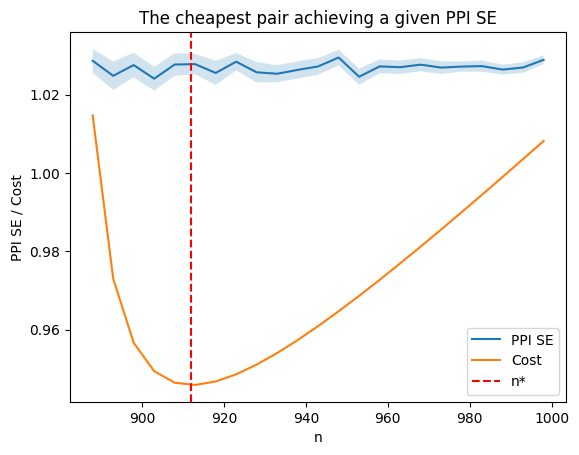

In [147]:
import matplotlib.pyplot as plt
gamma = 1/100
n_star = n0*(1-rho_intervention**2 + np.sqrt(gamma*rho_intervention**2*(1- rho_intervention**2)))
n_star = n_star.astype(int)
c_star = (1 - rho_intervention**2 + gamma*rho_intervention**2 + 2*np.sqrt(gamma*rho_intervention**2*(1- rho_intervention**2)))



cost = (ns + gamma*(ns + Ns))/n0

plt.plot(ns, ppi_ses.mean(axis = 1)*10, label="PPI SE")
sd = 2*ppi_ses.std(axis=1)*10/np.sqrt(reps)
plt.fill_between(ns, ppi_ses.mean(axis=1)*10 - sd, ppi_ses.mean(axis=1)*10 + sd, alpha=0.2)
plt.plot(ns, cost, label="Cost")
plt.axvline(x=n_star, color='r', linestyle='--', label="n*")
plt.title("The cheapest pair achieving a given PPI SE")
plt.xlabel("n")
plt.ylabel("PPI SE / Cost")
plt.legend()

In [148]:
rho_intervention = results2["rho"][0]
B = 1000
gamma = 1/100
n0 = B/(1 -  rho_intervention**2 + gamma*rho_intervention**2 + 2*np.sqrt(gamma*rho_intervention**2*(1- rho_intervention**2)))
nstar = n0*(1-rho_intervention**2 + np.sqrt(gamma*rho_intervention**2*(1- rho_intervention**2)))
nstar = nstar.astype(int)
print(nstar)



ns = np.arange(nstar - (B - nstar), B+5, 5)
ns = ns.astype(int)
Ns = (B - (1+gamma)*ns)/gamma
Ns = Ns.astype(int)
ns = ns[Ns > 0]
Ns = Ns[Ns > 0]
reps = 100
ppi_ses2 = np.zeros((len(ns),reps))

x = "Intervention"	
y = "gpt4turbo_wp_Saved"

for i, n in enumerate(ns):
    N = Ns[i]
    print(f"n: {n}, N: {N}")
    for r in range(reps):
        # sample dilemmas for human subjects sample
        n_ids = random.sample(sorted(ids), k=n)
        
        # get remaining dilemma ids to sample from
        remaining_ids = list(set(ids) - set(n_ids))

        # skip current iteration if target N is larger than population
        if (len(remaining_ids) < N):
            continue 
        
        # sample dilemmas for silicon subjects sample
        N_ids = random.sample(remaining_ids, k=N)

        # subset data
        df_human = df[ df["ResponseID"].isin(n_ids) ]
        df_silicon = df [ df["ResponseID"].isin(N_ids)]

        # pool human and silicon subject decisions
        df_pooled = pd.concat([df_human,df_silicon], ignore_index=True)

        # compute ppi acme
        ppi = compute_amce_ppi(n_data=df_human, N_data=df_silicon, x=x, y=y)

        ppi_ses2[i,r] = (ppi["conf_high_ppi"][0] - ppi["conf_low_ppi"][0])
    print(ppi_ses2[i].mean())

964
n: 928, N: 6272
0.10087912687905953
n: 933, N: 5766
0.10061023191168847
n: 938, N: 5262
0.10046741510178078
n: 943, N: 4756
0.10015632866635694
n: 948, N: 4251
0.10027116284466243
n: 953, N: 3747
0.10002488486238324
n: 958, N: 3241
0.10000521821340481
n: 963, N: 2737
0.09986253364262501
n: 968, N: 2231
0.09996589804971993
n: 973, N: 1726
0.09997047920448861
n: 978, N: 1222
0.10029949317052064
n: 983, N: 716
0.10118800826905121
n: 988, N: 212
0.10227077900046794


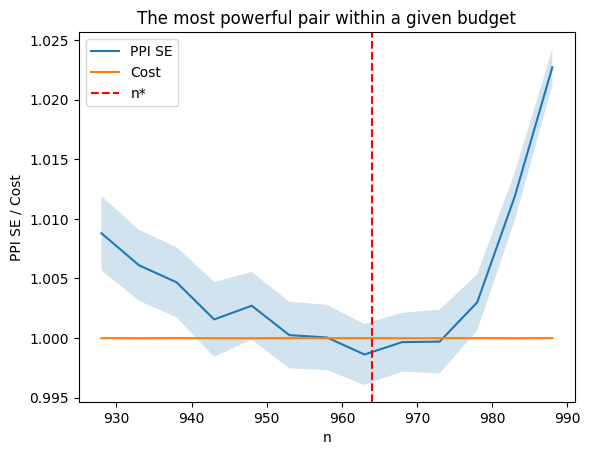

In [150]:

cost = (ns + gamma*(ns + Ns))/B

plt.plot(ns, ppi_ses2.mean(axis = 1)*10, label="PPI SE")
sd = 2*ppi_ses2.std(axis=1)*10/np.sqrt(reps)
plt.fill_between(ns, ppi_ses2.mean(axis=1)*10 - sd, ppi_ses2.mean(axis=1)*10 + sd, 
                alpha=0.2)
plt.plot(ns, cost, label="Cost")
plt.axvline(x=nstar, color='r', linestyle='--', label="n*")
plt.title("The most powerful pair within a given budget")
plt.xlabel("n")
plt.ylabel("PPI SE / Cost")
plt.legend()

